In [21]:
import numpy as np
import pylab as plt
import matplotlib.animation as animation
import matplotlib
from scipy.signal import welch
import seaborn as sns
import time
from IPython.display import HTML
import types

import tensorflow as tf
import tensorflow_probability as tfp

plt.style.use('ggplot')

# The Kuramoto class, borrowed from http://www.laszukdawid.com/codes, and modified to permit time-varying coupling.

In [2]:
from __future__ import print_function

import numpy as np
from scipy.integrate import ode

__version__ = '0.3'
__author__ = 'Dawid Laszuk'

class Kuramoto(object):
    """
    Implementation of Kuramoto coupling model [1] with harmonic terms
    and possible perturbation.
    It uses NumPy and Scipy's implementation of Runge-Kutta 4(5)
    for numerical integration.

    Usage example:
    >>> kuramoto = Kuramoto(initial_values)
    >>> phase = kuramoto.solve(X)
    """

    def __init__(self, init_values):
        """
        Passed arguments should be a dictionary with NumPy arrays
        for initial phase (Y0), intrisic frequencies (W) and coupling
        matrix (K).
        """
        self.dtype = np.float32

        self.dt = 1.
        self.init_phase = np.array(init_values['Y0'])
        self.W = np.array(init_values['W'])

        self.n_osc = len(self.W)

        if isinstance(init_values['K'], list) or isinstance(init_values['K'], types.GeneratorType):
            self.m_order = 1
            self.K = init_values['K']
        else:
            self.m_order = 1
            self.K = np.array(init_values['K'])
        

    def kuramoto_ODE(self, t, y, arg):
        """General Kuramoto ODE of m'th harmonic order.
           Argument `arg` = (w, k), with
            w -- iterable frequency
            k -- 3D coupling matrix, unless 1st order
            """

        w, k = arg
        yt = y[:,None]
        dy = y-yt
        phase = w.astype(self.dtype)
        for m, _k in enumerate(k):
            phase += np.sum(_k*np.sin((m+1)*dy),axis=1)

        return phase

    def kuramoto_ODE_jac(self, t, y, arg):
        """Kuramoto's Jacobian passed for ODE solver."""

        w, k = arg
        yt = y[:,None]
        dy = y-yt

        phase = [m*k[m-1]*np.cos(m*dy) for m in range(1,1+self.m_order)]
        phase = np.sum(phase, axis=0)

        for i in range(self.n_osc):
            phase[i,i] = -np.sum(phase[:,i])

        return phase

    def solve(self, t):
        """Solves Kuramoto ODE for time series `t` with initial
        parameters passed when initiated object.
        """
        dt = t[1]-t[0]

        kODE = ode(self.kuramoto_ODE, jac=self.kuramoto_ODE_jac)
        
        #kODE.set_integrator("dopri5", nsteps=20000)
        #kODE.set_integrator("lsoda", nsteps=20000)
        kODE.set_integrator("vode", nsteps=20000)
        
        # Set parameters into model
        kODE.set_initial_value(self.init_phase, t[0])
        
        if isinstance(self.K, np.ndarray):
            kODE.set_f_params((self.W, self.K))
            kODE.set_jac_params((self.W, self.K))
        elif isinstance(self.K, types.GeneratorType):
            throwAwayFirst = next(self.K)

        phase = np.empty((self.n_osc, len(t)))
        
        # Run ODE integrator
        for idx, _t in enumerate(t[1:]):
            if idx % int(len(t)/10) == 0:
                print(idx)
            if isinstance(self.K, list):
                kODE.set_f_params((self.W, self.K[idx]))
                kODE.set_jac_params((self.W, self.K[idx]))
            elif isinstance(self.K, types.GeneratorType):
                thisK = next(self.K)
                kODE.set_f_params((self.W, thisK))
                kODE.set_jac_params((self.W, thisK))
            phase[:,idx] = kODE.y
            kODE.integrate(_t)

        phase[:,-1] = kODE.y

        return phase

# Utility function definitions

In [3]:
# sum the oscillators into one signal
# phiMatrix = phases
# A = amplitudes
def sumOsc(phiMatrix, A):
    A = np.resize(A, (1, len(A)))
    return A.dot(np.sin(phiMatrix)).sum(0)

# make a generator of coupling matrices that evolve piecewise linearly
# KpointList is a list of coupling matrices
# changePoints is a list of time points at which the corresponding matrices hold
# In between the change points the matrices evolve linearly from first to second
# dt is the time step
def linearKGenerator(KpointList, changePoints, dt):
    for i in range(1,len(changePoints)):
        thisList = []
        startMatrix = KpointList[i-1]
        endMatrix = KpointList[i]
        numTimePoints = int(np.ceil((changePoints[i] - changePoints[i-1])/dt)) + 1
        for j in np.linspace(0,1,numTimePoints)[0:-1]:
            thisMatrix = ((1-j) * startMatrix) + (j * endMatrix)
            yield thisMatrix
    yield endMatrix

# Set the parameters for the Kuramoto model.

In [4]:
# set these simulation parameters
nOsc = 20
upperFreqBound = 10.0
upperTimeBound = 40
dt = 0.01

# Defining time array
numTimePoints = int(upperTimeBound/dt) + 1
T = np.linspace(0, upperTimeBound, numTimePoints)
 
# Y0, W, K, A are initial phase, intrinsic freq, amplitude and
# coupling K matrix (or list of K matricies) respectively 
# (note K can be arbitary, in particular inhomogeneous, in contrast to Kuramoto's original model)

Y0 = np.random.uniform(low=0.0, high=2*np.pi, size=nOsc)
#W = np.random.uniform(low=0.1, high=upperFreqBound, size=nOsc)
#W = np.random.normal(loc=upperFreqBound, scale=1, size=nOsc)
W = 10 * np.ones(shape=nOsc)
A = np.ones(nOsc)

allOnes = np.ones(shape=(nOsc,nOsc))
#K = linearKGenerator([K1,K1,K2,K1,K1],[0.,15.,20.,25.,40.],dt)

K = allOnes

# Passing parameters as a dictionary
init_params = {'W':W, 'K':K, 'Y0':Y0}

# Numerically solve the model and plot the results.

In [ ]:
# Running Kuramoto model
kuramoto = Kuramoto(init_params)
odePhi = kuramoto.solve(T)

In [85]:
a = tf.constant([1,2,3], dtype=np.double)
(a - a[:,None])

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[ 0.,  1.,  2.],
       [-1.,  0.,  1.],
       [-2., -1.,  0.]])>

In [24]:
def kuramoto_ODE(self, t, y, arg):
        """General Kuramoto ODE of m'th harmonic order.
           Argument `arg` = (w, k), with
            w -- iterable frequency
            k -- 3D coupling matrix, unless 1st order
            """

        w, k = arg
        yt = y[:,None]
        dy = y-yt
        phase = w.astype(self.dtype)
        for m, _k in enumerate(k):
            phase += np.sum(_k*np.sin((m+1)*dy),axis=1)

        return phase
    
def kuramoto_ODE_jac(y):
    """Kuramoto's Jacobian passed for ODE solver."""

    w, k = arg
    yt = y[:,None]
    dy = y-yt

    phase = [m*k[m-1]*np.cos(m*dy) for m in range(1,1+self.m_order)]
    phase = np.sum(phase, axis=0)

    for i in range(self.n_osc):
        phase[i,i] = -np.sum(phase[:,i])

    return phase

In [105]:
W_tf = tf.constant(W)
K_tf = tf.constant(1)

In [111]:
@tf.function
def kuramoto_ODE_tf(t,y):
    a = W_tf
    b = tf.reduce_sum(tf.sin(y - y[:,None]),1)
    c = (K_tf/nOsc) * b
    return a + b

In [112]:
y_init = tf.constant(Y0, dtype=tf.float64)
solution_times=tfp.math.ode.ChosenBySolver(final_time=upperTimeBound)

results = tfp.math.ode.BDF().solve(ode_fn=kuramoto_ODE_tf, 
                                   initial_time=tf.constant(0), 
                                   initial_state=tf.constant(y_init), 
                                   solution_times=solution_times, 
                                   jacobian_fn=None)

y0 = results.states[0]  # == dot(matrix_exp(A * t0), y_init)
y1 = results.states[1]  # == dot(matrix_exp(A * t1), y_init)

KeyboardInterrupt: 

In [120]:
t_init = tf.constant(0., dtype=tf.float64)
t0 = tf.constant(.5, dtype=tf.float64)
t1 = tf.constant(1., dtype=tf.float64)

y_init = tf.constant([1., 1.], dtype=tf.float64)
A = tf.constant([[-1., -2.], [-3., -4.]], dtype=tf.float64)

@tf.function
def ode_fn(t, y):
    return tf.linalg.matvec(A, y)

results = tfp.math.ode.BDF().solve(ode_fn, t_init, y_init,
                                   solution_times=tfp.math.ode.ChosenBySolver(final_time=tf.constant(1.0,dtype=tf.float64)))
y0 = results.states[0]  # == dot(matrix_exp(A * t0), y_init)
y1 = results.states[1]  # == dot(matrix_exp(A * t1), y_init)

In [5]:
# Computing phase dynamics
phaseDynamics = np.diff(odePhi)/dt
orderParameterAbs = [np.abs(np.exp(odePhi[:,i] * (0+1j)).sum())  for i in range(odePhi.shape[1])]

0
400
800
1200
1600
2000
2400
2800
3200
3600


In [6]:
odePhi[:,0] % (2 * np.pi)

array([2.53429437, 2.46802039, 3.80791572, 4.43182162, 5.54349837,
       0.75884414, 4.92026958, 1.30594727, 3.6793104 , 4.67269568,
       5.88524506, 5.04146031, 1.78826015, 4.92840742, 1.18651092,
       5.46362472, 6.04560524, 3.46812205, 2.22848535, 3.85035517])

In [7]:
phaseDynamics[:,-1]

array([10.0005783 , 10.00057834,  9.90823174, 10.0001923 ,  9.99870591,
        9.99999215,  9.97889849, 10.00008308, 10.2211502 , 10.0001921 ,
        9.99928107, 10.12815684, 10.00028422,  9.89158554, 10.00008321,
        9.99870597,  9.99928107, 10.00256026, 10.00041135,  9.8710481 ])

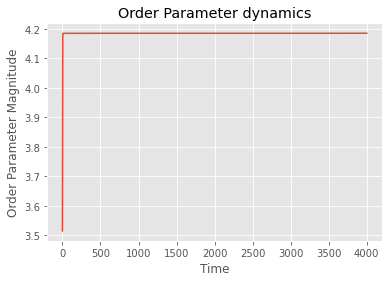

In [8]:
plt.figure()
plt.plot(orderParameterAbs)
plt.ylabel('Order Parameter Magnitude')
plt.xlabel('Time');
plt.title('Order Parameter dynamics');

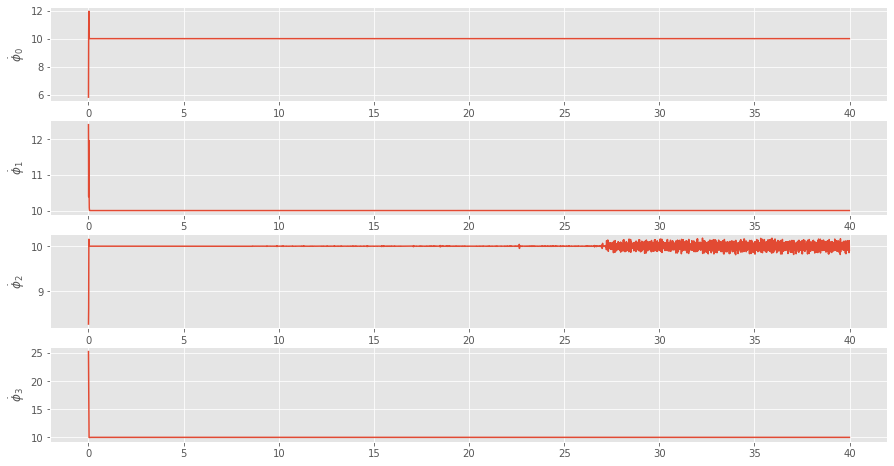

In [9]:
# Plotting response

oscList = range(4)

nOsc = len(oscList)
plt.figure(figsize=(15,2 * nOsc))
for i, osc in enumerate(oscList):
    plt.subplot(nOsc, 1, 1+i)
    plt.plot(T[:-1], phaseDynamics[osc])
    plt.ylabel("$\dot\phi_{%i}$" %(osc))
plt.show()

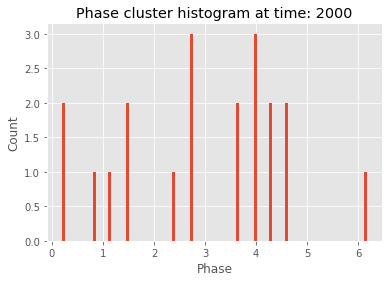

In [10]:
index = 2000

plt.figure()
plt.hist(np.mod(odePhi[:,index], 2*np.pi),100)
plt.xlabel('Phase');
plt.ylabel('Count');
plt.title('Phase cluster histogram at time: {}'.format(index))
plt.show()

# Plot the sum of the oscillators

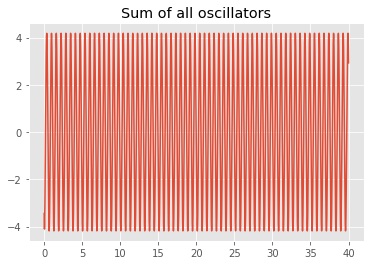

In [11]:
plt.figure()
sumSignal = sumOsc(odePhi, A)
plt.plot(T, sumSignal)
plt.title("Sum of all oscillators");

# Plot the frequency distribution of oscillators

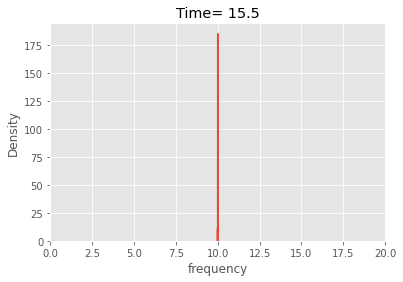

In [12]:
index = 1550

sns.kdeplot(phaseDynamics[:,index]);
plt.xlim([0,20])
plt.xlabel('frequency')
plt.title("Time= {}".format(index * dt));

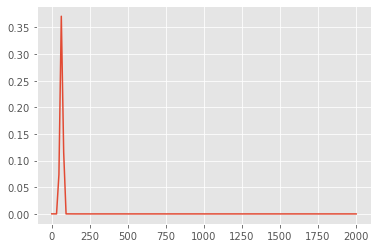

In [13]:
f, psd = welch(sumSignal, fs=upperTimeBound/dt)
plt.plot(f,psd);

In [14]:
'''
def linearKList(KpointList, changePoints, dt):
    Klist = []
    for i in range(1,len(changePoints)):
        thisList = []
        startMatrix = KpointList[i-1]
        endMatrix = KpointList[i]
        numTimePoints = int(np.ceil((changePoints[i] - changePoints[i-1])/dt)) + 1
        for j in np.linspace(0,1,numTimePoints)[0:-1]:
            thisMatrix = ((1-j) * startMatrix) + (j * endMatrix)
            thisList.append(thisMatrix.copy())
        Klist.extend(thisList)
    Klist.append(endMatrix.copy())
    return Klist
    
def negPosK(nOsc, probNeg):
    K = np.ones(shape=(nOsc,nOsc))
    for i in range(nOsc):
        for j in range(i):
            q = np.random.uniform()
            if q <= probNeg:
                K[i,j] = -1
                K[j,i] = -1
    return K
'''

'\ndef linearKList(KpointList, changePoints, dt):\n    Klist = []\n    for i in range(1,len(changePoints)):\n        thisList = []\n        startMatrix = KpointList[i-1]\n        endMatrix = KpointList[i]\n        numTimePoints = int(np.ceil((changePoints[i] - changePoints[i-1])/dt)) + 1\n        for j in np.linspace(0,1,numTimePoints)[0:-1]:\n            thisMatrix = ((1-j) * startMatrix) + (j * endMatrix)\n            thisList.append(thisMatrix.copy())\n        Klist.extend(thisList)\n    Klist.append(endMatrix.copy())\n    return Klist\n    \ndef negPosK(nOsc, probNeg):\n    K = np.ones(shape=(nOsc,nOsc))\n    for i in range(nOsc):\n        for j in range(i):\n            q = np.random.uniform()\n            if q <= probNeg:\n                K[i,j] = -1\n                K[j,i] = -1\n    return K\n'